In [1]:
# Importacion de librerias
# Conexión a la base de datos
# ==========================================
import os
import sys
import pathlib

sys.path.append(
    os.path.join(pathlib.Path(os.getcwd()).parent)
)

from utils.bq_conn import bq_conn_file


# Tratamiento de datos
# ==========================================
import pandas as pd
import numpy as np
from datetime import datetime

# Graficas
# ==========================================
%matplotlib inline
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import seaborn as sns
from matplotlib import style

# Modelos ML
# ==========================================
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from IPython.display import display

In [2]:
# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)

El número de filas del dataset: 26553
El número de columnas del dataset: 38


,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [6]:
secopI_filter = secop_I.filter(items=['tipo_de_contrato', 
                'id_grupo', 
                'cuantia_proceso',
                'departamento_ejecucion',
                'plazo_de_ejec_del_contrato_'
                'id_objeto_a_contratar',
                'dias_ejec_final_contrato',
                                      ])
secopI_filter.head(5)

,id_modalidad,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,departamento_ejecucion,cuantia_proceso,cuantia_contrato,id_grupo,detalle_del_objeto_a_contratar,plazo_de_ejec_del_contrato_,tiempo_adiciones_en_dias,dias_ejec_final_contrato,valor_contrato_con_adiciones
0,13,celebrado,50000000,suministro,cundinamarca,50000000,50000000,E,contratar servicio suministro elementos materi...,330,0,330,50000000
1,12,celebrado,53000000,prestacion de servicios,bogota,22980096902,22980096902,E,adquisicion uniformes para dotar personal cuer...,660,30,690,22980096902
2,12,celebrado,55000000,prestacion de servicios,bogota,35998452,35998452,E,contratar diseno produccion tarjetas presentac...,31,40,71,35998452
3,12,liquidado,72000000,prestacion de servicios,bogota,16767536,16767536,F,prestar servicio mantenimiento preventivo corr...,170,0,170,16767536
4,19,celebrado,73000000,no encontrado en hoja proceso,bogota,0,0,F,desintegracion vehiculos automotores estado in...,360,0,360,0


## Análisis 


In [7]:
print("Dimensions: ", secopI_filter.shape)
num_row = secopI_filter.shape[0]
num_col = secopI_filter.shape[1]
print(secopI_filter.dtypes)

Dimensions:  (26553, 13)
id_modalidad                       Int64
estado_del_proceso                object
id_objeto_a_contratar              Int64
tipo_de_contrato                  object
departamento_ejecucion            object
cuantia_proceso                    Int64
cuantia_contrato                   Int64
id_grupo                          object
detalle_del_objeto_a_contratar    object
plazo_de_ejec_del_contrato_        Int64
tiempo_adiciones_en_dias           Int64
dias_ejec_final_contrato           Int64
valor_contrato_con_adiciones       Int64
dtype: object


In [8]:
# Se especifica variables categoricas
secopI_filter['estado_del_proceso'] = secopI_filter['estado_del_proceso'].astype('category')
secopI_filter['tipo_de_contrato'] = secopI_filter['tipo_de_contrato'].astype('category')
secopI_filter['departamento_ejecucion'] = secopI_filter['departamento_ejecucion'].astype('category')
secopI_filter['id_grupo'] = secopI_filter['id_grupo'].astype('category')

In [9]:
# Se verfica las variables INT
secopI_filter[['id_modalidad','id_objeto_a_contratar',
               'cuantia_proceso','cuantia_contrato',
               'plazo_de_ejec_del_contrato_','tiempo_adiciones_en_dias',
               'dias_ejec_final_contrato','valor_contrato_con_adiciones'
               ]]=secopI_filter[['id_modalidad','id_objeto_a_contratar',
               'cuantia_proceso','cuantia_contrato',
               'plazo_de_ejec_del_contrato_','tiempo_adiciones_en_dias',
               'dias_ejec_final_contrato','valor_contrato_con_adiciones'
               ]].astype(int)

### Variable respuesta
Cuando se crea un modelo, es muy importante estudiar la distribución de la variable respuesta, ya que, a fin de cuentas, es lo que interesa predecir. En este caso vamos a predecir el **Tiempo recomendado en días para un contratro** esto se puede ver reflejado en la columna `dias_ejec_final_contrato`.

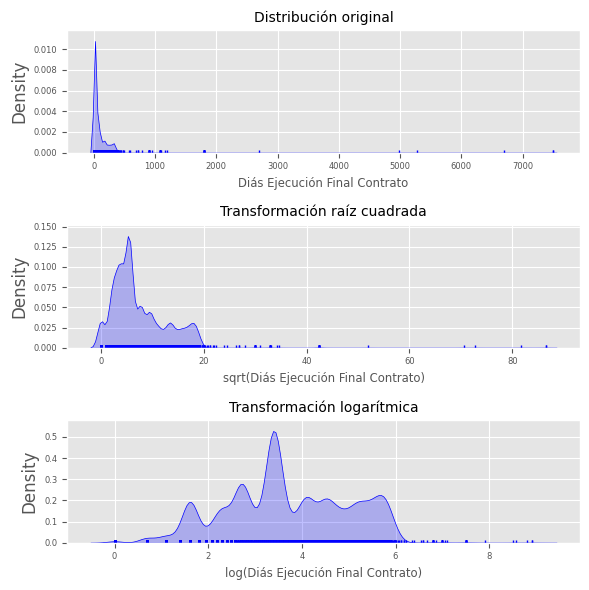

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    secopI_filter.dias_ejec_final_contrato,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    secopI_filter.dias_ejec_final_contrato,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Diás Ejecución Final Contrato', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(secopI_filter.dias_ejec_final_contrato),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(secopI_filter.dias_ejec_final_contrato),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Diás Ejecución Final Contrato)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(secopI_filter.dias_ejec_final_contrato),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(secopI_filter.dias_ejec_final_contrato),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Diás Ejecución Final Contrato)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

Como podemos observar en las distribuciones tenemos gran presencia de outliers en nuestra variable de predicción esto podia ocasionar problemas a la hora de ejecutar los modelos ya que su varianza crece y afecta al modelo. Por este motivo a continuación realizaremos un Tratamiento de estos **outliers**.

In [16]:
secopI_filter['dias_ejec_final_contrato'].describe()

count    26552.000000
mean        80.238739
std        137.982206
min          0.000000
25%         15.000000
50%         30.000000
75%         99.000000
max       7500.000000
Name: dias_ejec_final_contrato, dtype: float64

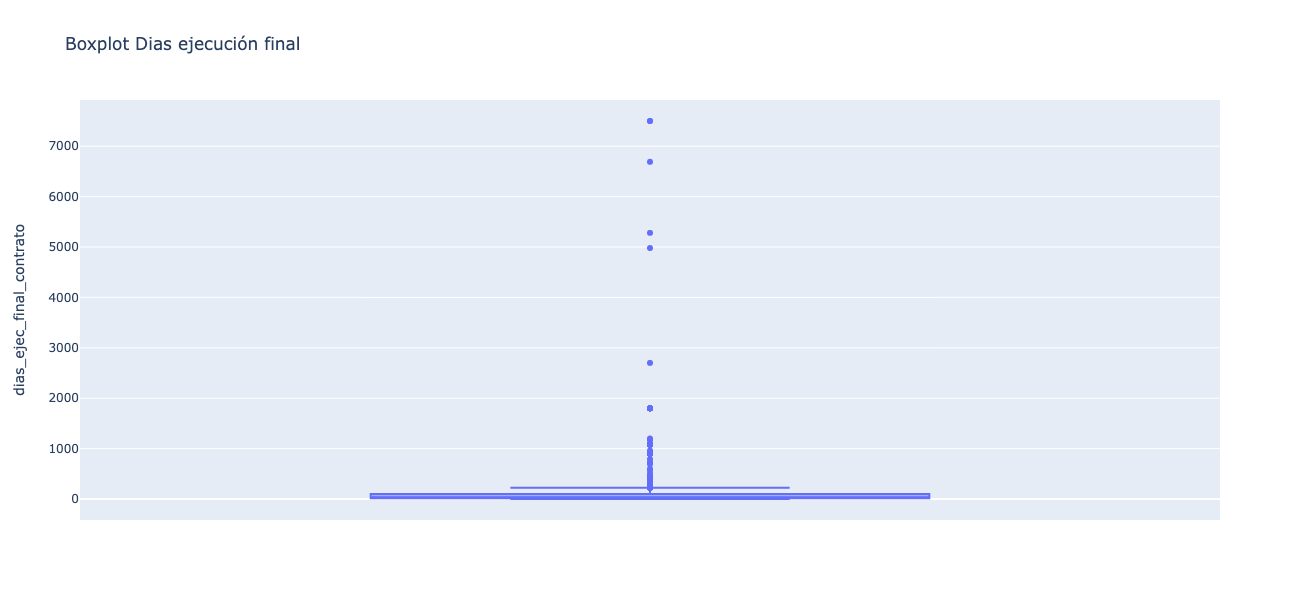

In [68]:
fig = px.box(secopI_filter, y="dias_ejec_final_contrato", title="Boxplot Dias ejecución final")
# Ajusta el tamaño del gráfico
fig.update_layout(
    width=800,  # Ancho en píxeles
    height=600  # Alto en píxeles
)

fig.show()

#### Tratamiento de outliers
La variable 'dias_ejec_final_contrato' representa la duración de los contratos en días. Aquí hay un resumen estadístico de esta variable:

Mínimo: 0 días 
Primer cuartil (Q1): 15 días
Mediana: 30 días
Tercer cuartil (Q3): 99 días
Máximo: 7500 días
Media: 80.24 días
Desviación estándar: 137.98 días
Dado que la diferencia entre el máximo y el tercer cuartil es bastante grande, se comprueba la existencia outliers en esta variable. El tratamiento que vamos a utilizar para minimizar este problema es:

* Desviaciones estándar: Elimina los valores que estén a más o menos tres desviaciones estándar de la media. Esto eliminará aproximadamente el 0,3% de los valores más extremos.

Como tenemos outliers muy extremos, se considero eliminarlos usando desviaciones estándar. 

In [38]:
#Calcula la media y la desviación estándar de la variable de interés:
mean = secopI_filter['dias_ejec_final_contrato'].mean()
std_dev = secopI_filter['dias_ejec_final_contrato'].std()
#Establece un umbral de desviaciones estándar (usualmente 3 desviaciones estándar):
threshold = 3
# Encuentra los outliers utilizando el criterio de desviaciones estándar
secopI_filter_no_outliers = secopI_filter[np.abs(secopI_filter['dias_ejec_final_contrato'] - mean) <= threshold * std_dev]
print("DataFrame sin outliers:")
# Dimensiones del dataset
# ==============================================================================
print(f"El número de filas del dataset: {secopI_filter.shape[0]}\nEl número de columnas del dataset: {secopI_filter.shape[1]}")
#secopI_filter_no_outliers.head(2)


DataFrame sin outliers:
El número de filas del dataset: 26552
El número de columnas del dataset: 13


In [19]:
import numpy as np
# Tratamiento de outliers
Q1 = np.percentile(secopI_filter['dias_ejec_final_contrato'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(secopI_filter['dias_ejec_final_contrato'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
# Upper bound
upper = Q3+1.5*IQR
upper_array = secopI_filter.loc[secopI_filter['dias_ejec_final_contrato']>=upper].index.to_list()

# Lower bound
lower = Q1-1.5*IQR
lower_array = secopI_filter.loc[secopI_filter['dias_ejec_final_contrato']<=lower].index.to_list()

# Removing the outliers
outliers = upper_array + lower_array
secopI_filter_no_outliers = secopI_filter.drop(outliers)

print(f"El número de filas del dataset: {secopI_filter_no_outliers.shape[0]}\nEl número de columnas del dataset: {secopI_filter_no_outliers.shape[1]}")

El número de filas del dataset: 23377
El número de columnas del dataset: 13


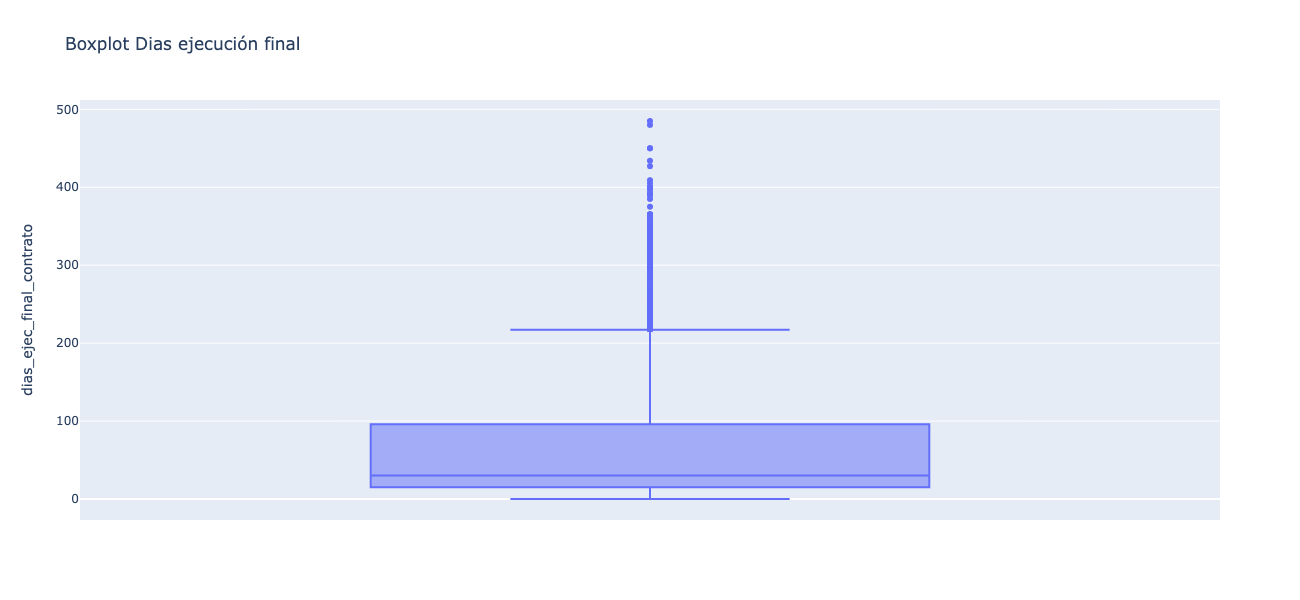

In [39]:
fig = px.box(secopI_filter_no_outliers, y="dias_ejec_final_contrato", title="Boxplot Dias ejecución final")
# Ajusta el tamaño del gráfico
fig.update_layout(
    width=800,  # Ancho en píxeles
    height=600  # Alto en píxeles
)

fig.show()

Algunos modelos de machine learning y aprendizaje estadístico requieren que la variable respuesta se distribuya de una forma determinada. Por ejemplo, para los modelos de regresión lineal (LM), la distribución tiene que ser de tipo normal. Para los modelos lineales generalizados (GLM), la distribución tiene que ser de la familia exponencial.

Existen varias librerías en python que permiten identificar a qué distribución se ajustan mejor los datos, una de ellas es fitter. Esta librería permite ajustar cualquiera de las 80 distribuciones implementadas en scipy.


Fitting 9 distributions: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 10.78it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
exponpow,0.001916,1629.460428,-435850.605169,inf,0.172426,0.0
cauchy,0.001930,1656.991970,-435661.170996,inf,0.236080,0.0
beta,0.001931,1494.199798,-435626.688775,inf,0.123562,0.0
expon,0.001948,1500.125980,-435425.946928,inf,0.250404,0.0
chi2,0.001980,1570.890947,-434976.428785,inf,0.136189,0.0
gamma,0.002132,1642.905803,-433016.806374,inf,0.195588,0.0
powerlaw,0.002200,1337.352120,-432188.003129,inf,0.167453,0.0
logistic,0.002664,1619.712618,-427125.726035,inf,0.232671,0.0
norm,0.002817,1608.837781,-425640.475861,inf,0.260975,0.0


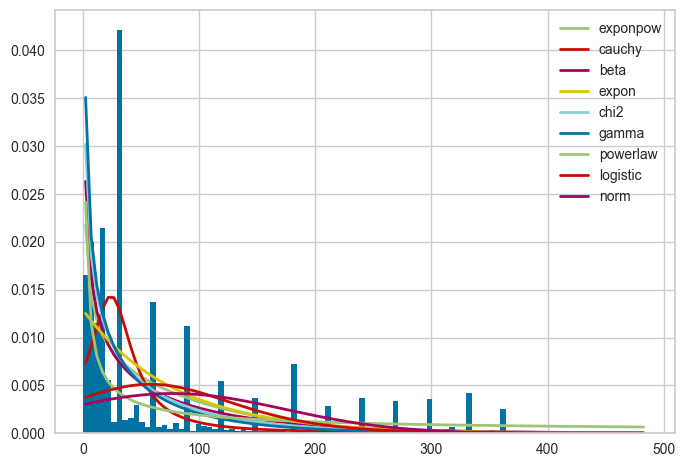

In [40]:
from fitter import Fitter, get_common_distributions
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(secopI_filter_no_outliers.dias_ejec_final_contrato, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=True)

### Variables numéricas

In [41]:
# Variables numéricas
# ==============================================================================
secopI_filter_no_outliers.select_dtypes(include=['float64', 'int']).describe()

,id_modalidad,id_objeto_a_contratar,cuantia_proceso,cuantia_contrato,plazo_de_ejec_del_contrato_,tiempo_adiciones_en_dias,dias_ejec_final_contrato,valor_contrato_con_adiciones
count,26509.000000,2.650900e+04,2.650900e+04,2.650900e+04,26509.000000,26509.000000,26509.000000,2.650900e+04
mean,12.851673,4.764782e+07,1.867019e+07,1.383085e+07,76.275906,1.176091,77.451997,1.460870e+07
std,0.539827,1.986334e+07,8.785377e+07,1.027349e+08,94.624271,9.564400,96.010816,1.044615e+08
min,1.000000,1.000000e+07,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
25%,13.000000,4.300000e+07,1.500000e+06,1.067200e+06,15.000000,0.000000,15.000000,1.092000e+06
50%,13.000000,5.000000e+07,4.500000e+06,3.362100e+06,30.000000,0.000000,30.000000,3.474000e+06
75%,13.000000,5.300000e+07,1.600000e+07,1.050000e+07,90.000000,0.000000,96.000000,1.100028e+07
max,19.000000,9.500000e+07,5.601799e+09,1.200000e+10,480.000000,240.000000,485.000000,1.200000e+10


Como el objetivo del estudio es predecir el los dias totales de ejecución del contrato del INPEC, el análisis de cada variable se hace también en relación a la variable respuesta `dias_ejec_final_contrato`. Analizando los datos de esta forma, se pueden empezar a extraer ideas sobre qué variables están más relacionadas con el precio y de qué forma.

Text(0.5, 0.98, 'Correlación con días ejec final del contrato')

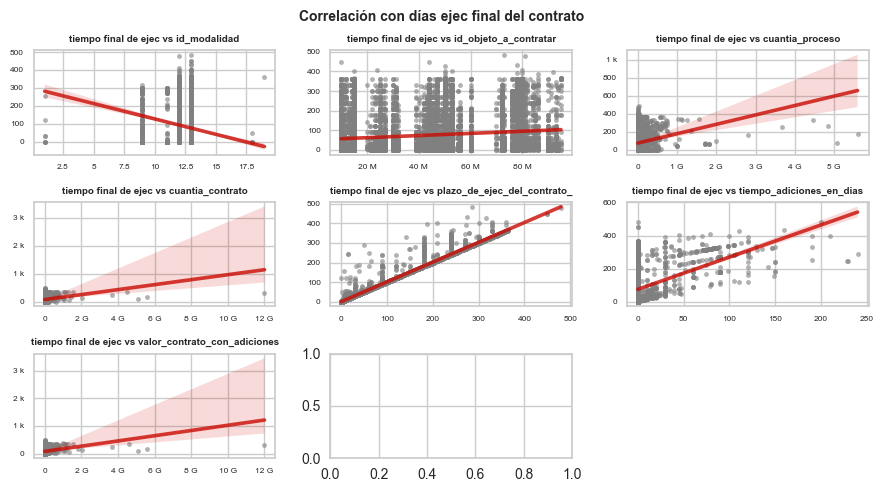

In [42]:

# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(9, 5))
axes = axes.flat
columnas_numeric = secopI_filter_no_outliers.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('dias_ejec_final_contrato')

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = secopI_filter_no_outliers[colum],
        y           = secopI_filter_no_outliers['dias_ejec_final_contrato'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.6},
        line_kws    = {"color":"r","alpha":0.8},
        ax          = axes[i]
    )
    axes[i].set_title(f"tiempo final de ejec vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con días ejec final del contrato', fontsize = 10, fontweight = "bold")

### Correlación variables numéricas
Algunos modelos (LM, GLM, ...) se ven perjudicados si incorporan predictores altamente correlacionados. Por esta razón, es conveniente estudiar el grado de correlación entre las variables disponibles.

In [43]:
# Correlación entre columnas numéricas
# ==============================================================================
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = secopI_filter_no_outliers.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
59,valor_contrato_con_adiciones,cuantia_contrato,0.996455,0.996455
31,cuantia_contrato,valor_contrato_con_adiciones,0.996455,0.996455
52,dias_ejec_final_contrato,plazo_de_ejec_del_contrato_,0.995071,0.995071
38,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,0.995071,0.995071
58,valor_contrato_con_adiciones,cuantia_proceso,0.596177,0.596177
23,cuantia_proceso,valor_contrato_con_adiciones,0.596177,0.596177
26,cuantia_contrato,cuantia_proceso,0.585311,0.585311
19,cuantia_proceso,cuantia_contrato,0.585311,0.585311
2,id_modalidad,cuantia_proceso,-0.329903,0.329903
16,cuantia_proceso,id_modalidad,-0.329903,0.329903


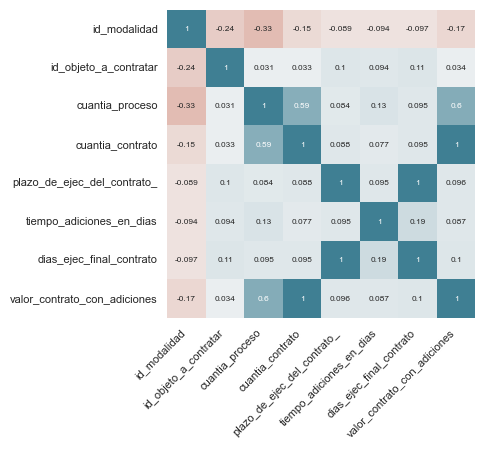

In [44]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

En la tabla y en el heatmap se muestra la correlación entre diferentes variables en el conjunto de datos. La columna "r" representa el coeficiente de correlación de Pearson entre dos variables, mientras que la columna "abs_r" muestra el valor absoluto de ese coeficiente.

observaciones sobre la tabla:

* Las variables `cuantia_contrato` y `valor_contrato_con_adiciones` tienen una correlación muy alta (0.998726), lo que indica que están fuertemente relacionadas. Es probable que cuando el valor de uno aumenta, el otro también lo haga.

* Las variables `dias_ejec_final_contrato` y `plazo_de_ejec_del_contrato_` también tienen una alta correlación (0.997577), lo que sugiere que están estrechamente relacionadas. 

* La correlación entre `cuantia_proceso` y `cuantia_contrato`, así como entre `cuantia_proceso` y `valor_contrato_con_adiciones` también es alta (0.869700 y 0.868296, respectivamente). Esto sugiere que existe una relación significativa entre la cuantía del proceso y las otras dos variables mencionadas.

* La correlación entre `id_modalidad` e `id_objeto_a_contratar` es negativa (-0.238309), aunque el valor absoluto es bajo. Esto indica que la relación entre estas dos variables no es muy fuerte, y cuando una aumenta, la otra podría disminuir ligeramente.

En resumen, la tabla muestra correlaciones fuertes entre varias variables, especialmente en lo que respecta a la cuantía y la duración del contrato.

A continuación eliminaremos la variables que estan fuertemente relacionadas.

In [45]:
secopI_filter_no_outliers = secopI_filter_no_outliers.drop(['valor_contrato_con_adiciones','tiempo_adiciones_en_dias','cuantia_contrato','cuantia_proceso', 'plazo_de_ejec_del_contrato_'], axis=1)

### Variables cualitativas

In [46]:
# Variables cualitativas (tipo object)
# ==============================================================================
secopI_filter_no_outliers.select_dtypes(include=['object', 'category']).describe()

,estado_del_proceso,tipo_de_contrato,departamento_ejecucion,id_grupo,detalle_del_objeto_a_contratar
count,26509,26509,26509,26509,26509
unique,7,11,31,7,20012
top,celebrado,suministro,antioquia,E,productos alimenticios expendio
freq,13501,11761,3278,15864,73


### División train y test

In [47]:
# conjunto de datos train
train_datos = secopI_filter_no_outliers.sample(frac=0.9, random_state=0)
# conjunto de datos test
test_datos = secopI_filter_no_outliers.drop(train_datos.index)

In [48]:
train_datos.head(2)

,id_modalidad,estado_del_proceso,id_objeto_a_contratar,tipo_de_contrato,departamento_ejecucion,id_grupo,detalle_del_objeto_a_contratar,dias_ejec_final_contrato
25410,13,liquidado,53000000,suministro,caldas,E,suministro elementos seguridad industrial tale...,120
14058,13,liquidado,50000000,suministro,boyaca,E,suministro bebidas para expendio establecimien...,270


### Preprocesado


El preprocesado engloba todas aquellas transformaciones realizadas sobre los datos con el objetivo que puedan ser interpretados por el algoritmo de machine learning lo más eficientemente posible. Todo preprocesado de datos debe aprenderse con las observaciones de entrenamiento y luego aplicarse al conjunto de entrenamiento y al de test. Esto es muy importante para no violar la condición de que ninguna información procedente de las observaciones de test participe o influya en el ajuste del modelo. Este principio debe aplicarse también si se emplea validación cruzada (ver más adelante). En tal caso, el preprocesado debe realizarse dentro de cada iteración de validación, para que las estimaciones que se hacen con cada partición de validación no contengan información del resto de particiones. Aunque no es posible crear un único listado, a continuación se resumen algunos de los pasos de preprocesado que más se suelen necesitar.

#### 1. Estandarización y escalado de variables numéricas


Cuando los predictores son numéricos, la escala en la que se miden, así como la magnitud de su varianza pueden influir en gran medida en el modelo. Muchos algoritmos de machine learning (SVM, redes neuronales, lasso...) son sensibles a esto, de forma que, si no se igualan de alguna forma los predictores, aquellos que se midan en una escala mayor o que tengan más varianza dominarán el modelo aunque no sean los que más relación tienen con la variable respuesta.

Normalización (estandarización): consiste en transformar los datos de forma que todos los predictores estén aproximadamente en la misma escala. Se escoge StanderScaler para la normalización de nuestro dataset

* Normalización Z-score (`StandardScaler`): dividir cada predictor entre su desviación típica después de haber sido centrado, de esta forma, los datos pasan a tener una distribución normal.

 #### 2. Binarización de las variables cualitativas


La binarización (one-hot-encoding) consiste en crear nuevas variables dummy con cada uno de los niveles de las variables cualitativas. Por ejemplo, una variable llamada color que contenga los niveles rojo, verde y azul, se convertirá en tres nuevas variables (color_rojo, color_verde, color_azul), todas con el valor 0 excepto la que coincide con la observación, que toma el valor 1.

Por defecto, la clase `OneHotEncoder` binariza todas las variables, por lo que hay que aplicarlo únicamente a las variables cualitativas (ver como hacerlo en el apartado ColumnTransformer). Con el argumento `drop=‘first’` se elimina uno de los niveles para evitar redundancias. Volviendo al ejemplo anterior, no es necesario almacenar las tres variables, ya que, si color_rojo y color_verde toman el valor 0, la variable color_azul toma necesariamente el valor 1. Si color_rojo o color_verde toman el valor 1, entonces color_azul es necesariamente 0. Esto es importante en modelos que sufren problemas si los predictores están perfectamente correlacionados (modelos lineales sin regularización, redes neuronales...).

En ciertos escenarios puede ocurrir que, en los datos de test, aparezca un nuevo nivel que no estaba en los datos de entrenamiento. Si no se conoce de antemano cuáles son todos los posibles niveles, se puede evitar errores en las predicciones indicando `OneHotEncoder(handle_unknown='ignore')`.


#### 3. ColumnTransformer


Las clases ColumnTransformer y make_column_transformer del módulo sklearn.compose permiten combinar múltiples transformaciones de preprocesado, especificando a qué columnas se aplica cada una. Como todo transformer, tiene un método de entrenamiento (fit) y otro de transformación (transform) 

In [49]:
secopI_filter_preprocess = secopI_filter_no_outliers.copy()
text_feature = secopI_filter_preprocess[['detalle_del_objeto_a_contratar']]
secopI_filter_preprocess.drop(['detalle_del_objeto_a_contratar'], axis=1, inplace=True)

In [50]:
numeric_cols = secopI_filter_preprocess.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = secopI_filter_preprocess.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)],
                remainder = 'passthrough',
                verbose_feature_names_out = False
               ).set_output(transform="pandas")

X_train_prep = preprocessor.fit_transform(train_datos)
X_test_prep  = preprocessor.transform(test_datos)

X_train_prep_text = X_train_prep



In [51]:
# X_train_prep.drop(['detalle_del_objeto_a_contratar'], axis=1, inplace=True)
X_train_prep_text.head(3)

,id_modalidad,id_objeto_a_contratar,dias_ejec_final_contrato,estado_del_proceso_adjudicado,estado_del_proceso_borrador,estado_del_proceso_celebrado,estado_del_proceso_convocado,estado_del_proceso_descartado,estado_del_proceso_liquidado,estado_del_proceso_terminado sin liquidar,...,departamento_ejecucion_tolima,departamento_ejecucion_valle del cauca,id_grupo_A,id_grupo_B,id_grupo_C,id_grupo_D,id_grupo_E,id_grupo_F,id_grupo_G,detalle_del_objeto_a_contratar
25410,0.275361,0.267645,0.441668,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,suministro elementos seguridad industrial tale...
14058,0.275361,0.116670,2.003251,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,suministro bebidas para expendio establecimien...
6630,0.275361,0.267645,-0.724314,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,adquirir elementos seguridad industrial materi...


### Modelo - Regression sin utilizar text features

In [52]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(X_train_prep, 
          # pca=True,
          target = 'dias_ejec_final_contrato',
          remove_multicollinearity=True,
          remove_outliers=True,
          #feature_selection=True, 
          fold=10, train_size= 0.8,
          preprocess=True,
          session_id = 123)
models()

,Description,Value
0,Session id,123
1,Target,dias_ejec_final_contrato
2,Target type,Regression
3,Original data shape,"(23858, 60)"
4,Transformed data shape,"(22906, 60)"
5,Transformed train set shape,"(18134, 60)"
6,Transformed test set shape,"(4772, 60)"
7,Numeric features,58
8,Categorical features,1
9,Preprocess,True


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [53]:
# compare models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.5387,0.6096,0.7807,0.3949,0.3348,1.2034,0.6130
lightgbm,Light Gradient Boosting Machine,0.5381,0.6171,0.7854,0.3875,0.3369,1.1985,0.1310
xgboost,Extreme Gradient Boosting,0.5350,0.6191,0.7867,0.3854,0.3338,1.2048,0.9030
rf,Random Forest Regressor,0.5247,0.6516,0.8071,0.3531,0.3210,1.2823,0.6810
gbr,Gradient Boosting Regressor,0.5939,0.6751,0.8216,0.3300,0.3730,1.1532,0.3550
et,Extra Trees Regressor,0.5250,0.6816,0.8255,0.3233,0.3216,1.2956,0.8840
knn,K Neighbors Regressor,0.5549,0.7166,0.8464,0.2886,0.3379,1.2830,0.1630
dt,Decision Tree Regressor,0.5448,0.7451,0.8630,0.2605,0.3272,1.3604,0.1150
ridge,Ridge Regression,0.6501,0.7804,0.8833,0.2255,0.3932,1.1876,0.0990
br,Bayesian Ridge,0.6506,0.7804,0.8833,0.2255,0.3938,1.1845,0.1350


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## Analizar modelo
La función plot_model se utiliza para analizar el rendimiento de un modelo entrenado en el conjunto de prueba. Puede requerir volver a entrenar el modelo en ciertos casos.

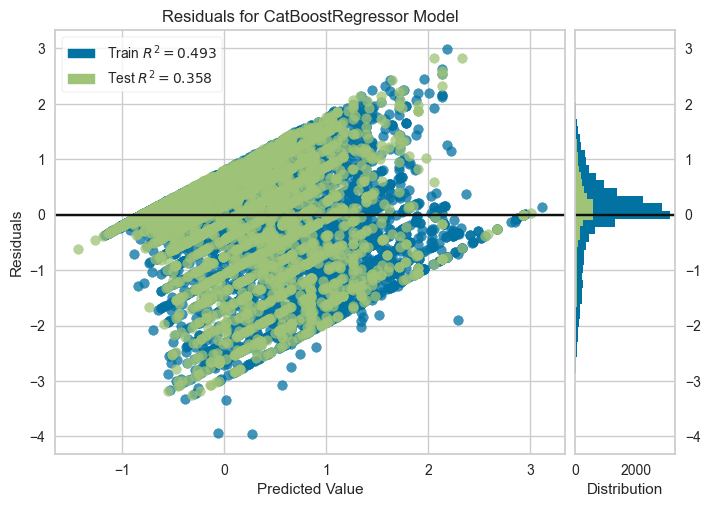

In [54]:
# plot residuals
plot_model(best, plot = 'residuals')

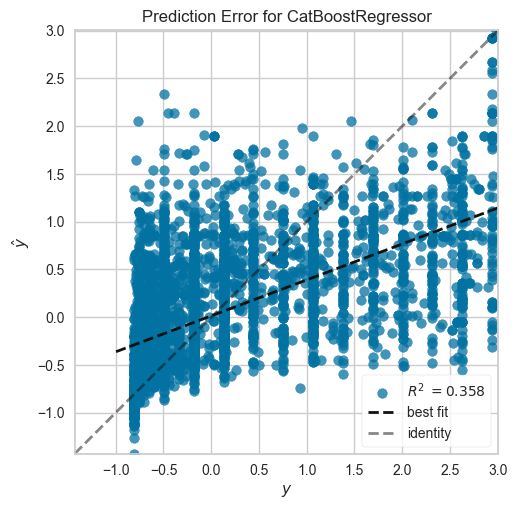

In [55]:
# plot error
plot_model(best, plot = 'error')

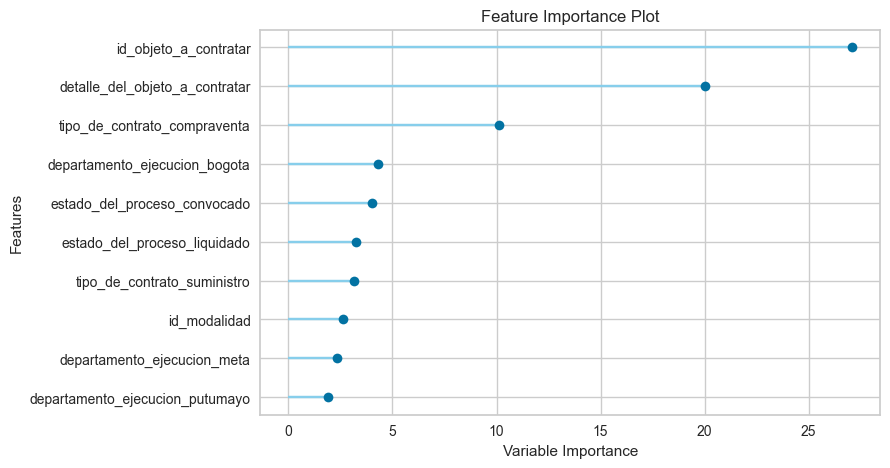

In [56]:
# plot feature importance
plot_model(best, plot = 'feature')

### Modelo - Regression sin utilizar text features

In [57]:
# import pycaret regression and init setup
from pycaret.regression import *
s = setup(X_train_prep_text, 
          # pca=True,
          target = 'dias_ejec_final_contrato', 
          #feature_selection=True,
          text_features = ['detalle_del_objeto_a_contratar'],
          fold=10, train_size= 0.8,
          preprocess=True,
          session_id = 123)
models()

,Description,Value
0,Session id,123
1,Target,dias_ejec_final_contrato
2,Target type,Regression
3,Original data shape,"(23858, 60)"
4,Transformed data shape,"(23858, 6792)"
5,Transformed train set shape,"(19086, 6792)"
6,Transformed test set shape,"(4772, 6792)"
7,Numeric features,58
8,Text features,1
9,Preprocess,True


,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [58]:
# compare models
#best = compare_models()
ct = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4935,0.5046,0.7103,0.4938,0.3188,1.0073
1,0.4890,0.5058,0.7112,0.4835,0.3221,1.0558
2,0.5078,0.5425,0.7366,0.4577,0.3281,1.2024
3,0.5280,0.5668,0.7528,0.4523,0.3348,1.1517
4,0.5139,0.5450,0.7382,0.4377,0.3331,1.2118
5,0.4922,0.5031,0.7093,0.5097,0.3171,1.1151
6,0.5160,0.5322,0.7295,0.4625,0.3237,1.0899
7,0.5189,0.5533,0.7438,0.4858,0.3339,1.1346
8,0.4932,0.4957,0.7041,0.5006,0.3212,1.0308


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

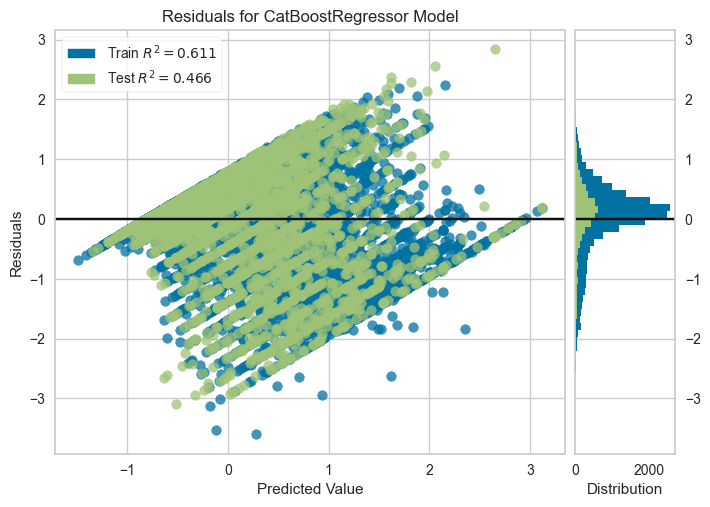

In [59]:
# plot residuals
plot_model(ct, plot = 'residuals')

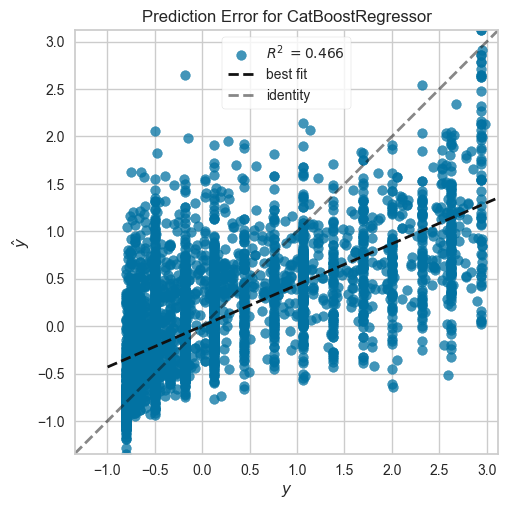

In [60]:
# plot error
plot_model(ct, plot = 'error')

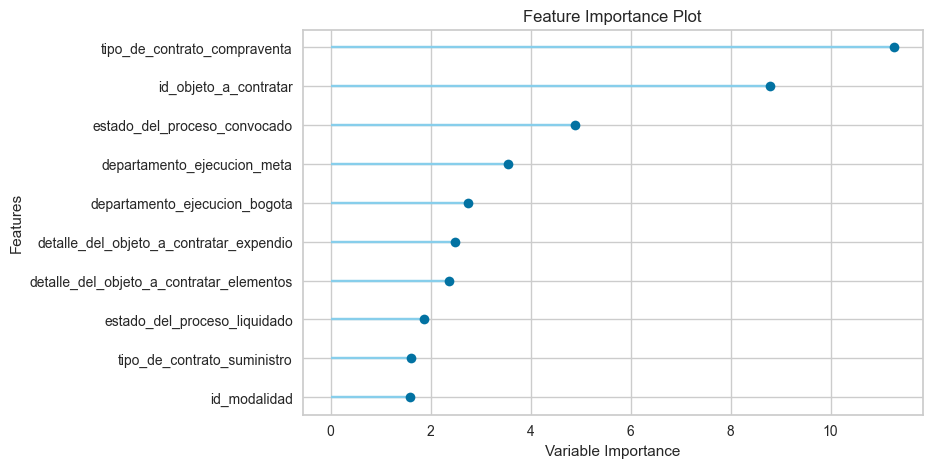

In [61]:
# plot feature importance
plot_model(ct, plot = 'feature')

In [62]:
# tune model
tuned_model, tuner = tune_model(ct,
                      choose_better = True, 
                      return_tuner=True,
                     #search_library = 'tune-sklearn', search_algorithm = 'hyperopt'
                     )
                      #search_library = 'optuna') 
                      #search_algorithm = 'hyperopt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5001,0.5167,0.7188,0.4816,0.3201,1.0555
1,0.4961,0.5119,0.7155,0.4773,0.3242,1.0771
2,0.5030,0.5405,0.7352,0.4597,0.3208,1.2463
3,0.5222,0.5563,0.7459,0.4624,0.3337,1.1540
4,0.5176,0.5564,0.7459,0.4259,0.3330,1.2651
5,0.4943,0.5113,0.7150,0.5017,0.3161,1.1467
6,0.5180,0.5410,0.7355,0.4536,0.3252,1.1146
7,0.5204,0.5524,0.7432,0.4866,0.3338,1.1191
8,0.4928,0.4987,0.7062,0.4976,0.3174,1.0784


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


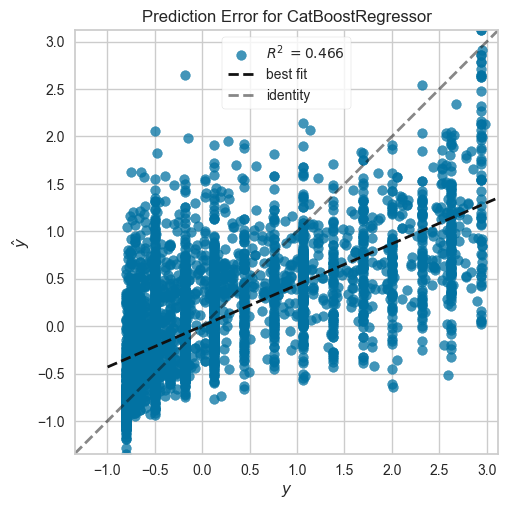

In [75]:
plot_model(tuned_model, plot = 'error')

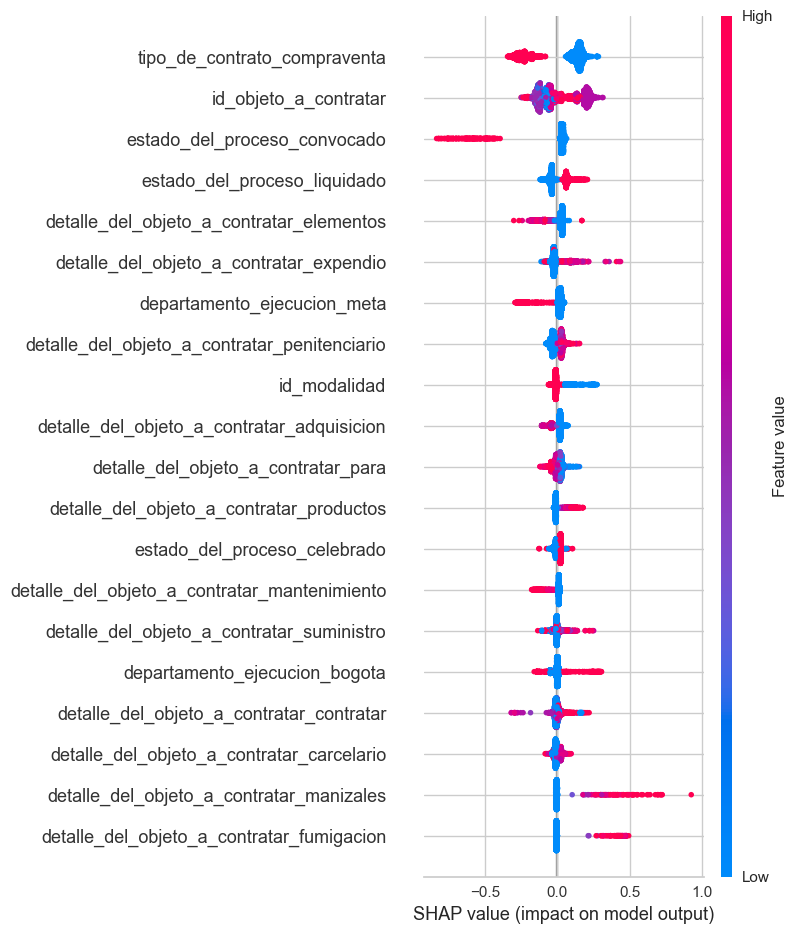

In [76]:
# interpret model
interpret_model(tuned_model)

In [72]:
tuned_model, tuner = tune_model(ct,
                      optimize = 'R2',
                      return_tuner=True)
      

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5001,0.5167,0.7188,0.4816,0.3201,1.0555
1,0.4961,0.5119,0.7155,0.4773,0.3242,1.0771
2,0.5030,0.5405,0.7352,0.4597,0.3208,1.2463
3,0.5222,0.5563,0.7459,0.4624,0.3337,1.1540
4,0.5176,0.5564,0.7459,0.4259,0.3330,1.2651
5,0.4943,0.5113,0.7150,0.5017,0.3161,1.1467
6,0.5180,0.5410,0.7355,0.4536,0.3252,1.1146
7,0.5204,0.5524,0.7432,0.4866,0.3338,1.1191
8,0.4928,0.4987,0.7062,0.4976,0.3174,1.0784


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [63]:
tuned_model

In [67]:
# ensemble model
bagged_model = ensemble_model(ct,
                      choose_better = True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4971,0.5114,0.7151,0.4870,0.3247,1.0040
1,0.4936,0.5168,0.7189,0.4722,0.3266,1.0540
2,0.5093,0.5469,0.7395,0.4534,0.3305,1.1617
3,0.5274,0.5615,0.7493,0.4574,0.3383,1.1282
4,0.5155,0.5471,0.7397,0.4355,0.3347,1.1767
5,0.4973,0.5114,0.7151,0.5016,0.3186,1.0949
6,0.5205,0.5392,0.7343,0.4555,0.3272,1.0847
7,0.5259,0.5633,0.7505,0.4765,0.3356,1.1155
8,0.4948,0.5005,0.7074,0.4958,0.3246,1.0406


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Original model was better than the ensembled model, hence it will be returned. NOTE: The display metrics are for the ensembled model (not the original one).


In [73]:
# ensemble model
# boosted_dt = ensemble_model(ct, method = 'Boosting')